In [1]:
import pandas as pd
import glob
import re
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)qtl', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)
        trait_match = re.search(r'(\d+)trait', filename)
        pleio_match = re.search(r'(\d+)pleio', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))
            trait_value = int(trait_match.group(1))
            pleio_value = int(pleio_match.group(1))


                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value
            df['n_trait'] = trait_value
            df['pleio'] = pleio_value


            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [3]:
linear_df = harvest_mod_outputs('./gplinear', 'qhaplo_*qtl_*n_*pleio_*trait_rep*_phenotype_correlations_untuned.csv')
neural_df = harvest_mod_outputs('./gpnet', 'qhaplo_*qtl_*n_*pleio_*trait_rep*_phenotype_correlations.csv')
linear_sklr = harvest_mod_outputs('./linear_model', 'qhaplo_*qtl_*n_*pleio_*trait_rep*_scklrr_corr_summary.txt')


   trait_number  pearson_correlation  p_value  true_mean  pred_mean  true_std  \
0             1             0.487265      0.0  -0.012515   0.029491  0.997945   
1             2             0.477062      0.0  -0.007013   0.028730  1.000042   
2             3             0.503262      0.0  -0.029288   0.063768  0.990669   
3             4             0.507306      0.0  -0.011081   0.004294  1.004711   
4             5             0.467553      0.0  -0.021740   0.007519  0.995503   

   pred_std trait_architecture  qtl_param  n_param  rep  n_trait  pleio  
0  0.201772                1-5       1000    10000    2       10     25  
1  0.205202                1-5       1000    10000    2       10     25  
2  0.208638                1-5       1000    10000    2       10     25  
3  0.205687                1-5       1000    10000    2       10     25  
4  0.211568                1-5       1000    10000    2       10     25  
   trait_number  pearson_correlation  true_mean  pred_mean  true_std 

In [4]:
linear_sklr.rename(columns={'pearson_corr_pheno_mean':'pearson_correlation'}, inplace=True)
linear_sklr.rename(columns={'trait':'trait_number'}, inplace=True)

linear_sklr

,trait_number,pearson_correlation,pearson_corr_pheno_std,pearson_corr_beta_mean,pearson_corr_beta_std,best_lambda_mean,best_lambda_std,qtl_param,n_param,rep,n_trait,pleio
0,1,0.545726,0.009504,0.964146,0.001973,148.496826,0.000000,300,10000,3,10,5
1,2,0.526869,0.011760,0.965413,0.002017,156.273809,16.395320,300,10000,3,10,5
2,3,0.574500,0.011268,0.970800,0.001301,148.496826,0.000000,300,10000,3,10,5
3,4,0.551311,0.012697,0.966372,0.001551,148.496826,0.000000,300,10000,3,10,5
4,5,0.543340,0.014574,0.960567,0.001360,148.496826,0.000000,300,10000,3,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...
13745,96,0.542243,0.019514,0.988993,0.000527,58.570208,0.000000,100,10000,1,100,25
13746,97,0.604956,0.011843,0.990980,0.000738,43.526261,4.652742,100,10000,1,100,25
13747,98,0.533982,0.023669,0.988089,0.000908,58.570208,0.000000,100,10000,1,100,25
13748,99,0.576257,0.012764,0.989575,0.001092,46.415888,0.000000,100,10000,1,100,25


In [5]:

def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep'])

    return common_params

# Get common parameter combinations
common_params = get_parameter_combinations(linear_sklr, neural_df)

In [6]:
comparison_data = []

for _, row in common_params.iterrows():
    qtl = row['qtl_param']
    n = row['n_param']
    trait = row['trait_number']
    pleio = row['pleio']
    n_trait = row['n_trait']
    rep = row['rep']

    linear_row = linear_sklr[(linear_sklr['qtl_param'] == qtl) &
                           (linear_sklr['n_param'] == n) &
                           (linear_sklr['trait_number'] == trait) &
                           (linear_sklr['pleio'] == pleio) &
                           (linear_sklr['n_trait'] == n_trait)&
                           (linear_sklr['rep'] == rep)]

    neural_row = neural_df[(neural_df['qtl_param'] == qtl) &
                           (neural_df['n_param'] == n) &
                           (neural_df['trait_number'] == trait) &
                           (neural_df['pleio'] == pleio) &
                           (neural_df['n_trait'] == n_trait) &
                           (neural_df['rep'] == rep)]

    if not linear_row.empty and not neural_row.empty:
        comparison_data.append({
            'qtl_param': qtl,
            'n_param': n,
            'trait_number': trait,
            'rep': rep,
            'pleio': pleio,
            'n_trait': n_trait,
            'linear_correlation': linear_row['pearson_correlation'].values[0],
            'neural_correlation': neural_row['pearson_correlation'].values[0],
            'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
        })

df = pd.DataFrame(comparison_data)

In [7]:
df.head(n=15)

,qtl_param,n_param,trait_number,rep,pleio,n_trait,linear_correlation,neural_correlation,difference
0,300,10000,1,3,5,10,0.545726,0.583150,0.068577
1,300,10000,2,3,5,10,0.526869,0.599054,0.137008
2,300,10000,3,3,5,10,0.574500,0.635838,0.106767
3,300,10000,4,3,5,10,0.551311,0.638470,0.158095
4,300,10000,5,3,5,10,0.543340,0.595737,0.096435
5,300,10000,6,3,5,10,0.533176,0.576501,0.081258
6,300,10000,7,3,5,10,0.541129,0.589332,0.089079
7,300,10000,8,3,5,10,0.558465,0.596956,0.068923
8,300,10000,9,3,5,10,0.570075,0.630339,0.105714
9,300,10000,10,3,5,10,0.549689,0.605517,0.101561


In [8]:
# Group by all columns except the numerical ones we want to average
groupby_columns = ['qtl_param', 'n_param', 'pleio', 'n_trait', 'rep']
agg_columns = ['linear_correlation', 'neural_correlation', 'difference']

# Perform the groupby and aggregation
summary_df = df.groupby(groupby_columns)[agg_columns].mean().reset_index()

# Rename the columns to indicate they are averages
summary_df = summary_df.rename(columns={
    'linear_correlation': 'avg_linear_correlation',
    'neural_correlation': 'avg_neural_correlation',
    'difference': 'avg_difference'
})

# Add a count column
count_df = df.groupby(groupby_columns).size().reset_index(name='count')
summary_df = pd.merge(summary_df, count_df, on=groupby_columns)

In [9]:
summary_df

,qtl_param,n_param,pleio,n_trait,rep,avg_linear_correlation,avg_neural_correlation,avg_difference,count
0,100,10000,0,10,1,0.568424,0.932372,0.647533,10
1,100,10000,0,10,2,0.569200,0.927681,0.639006,10
2,100,10000,0,10,3,0.593003,0.932105,0.580351,10
3,100,10000,0,10,4,0.555400,0.920858,0.670292,10
4,100,10000,0,10,5,0.588452,0.930336,0.593092,10
...,...,...,...,...,...,...,...,...,...
245,1000,10000,95,100,1,0.497455,0.485449,-0.024048,100
246,1000,10000,95,100,2,0.516834,0.506721,-0.019456,100
247,1000,10000,95,100,3,0.517447,0.479028,-0.074138,100
248,1000,10000,95,100,4,0.529039,0.503983,-0.047209,100


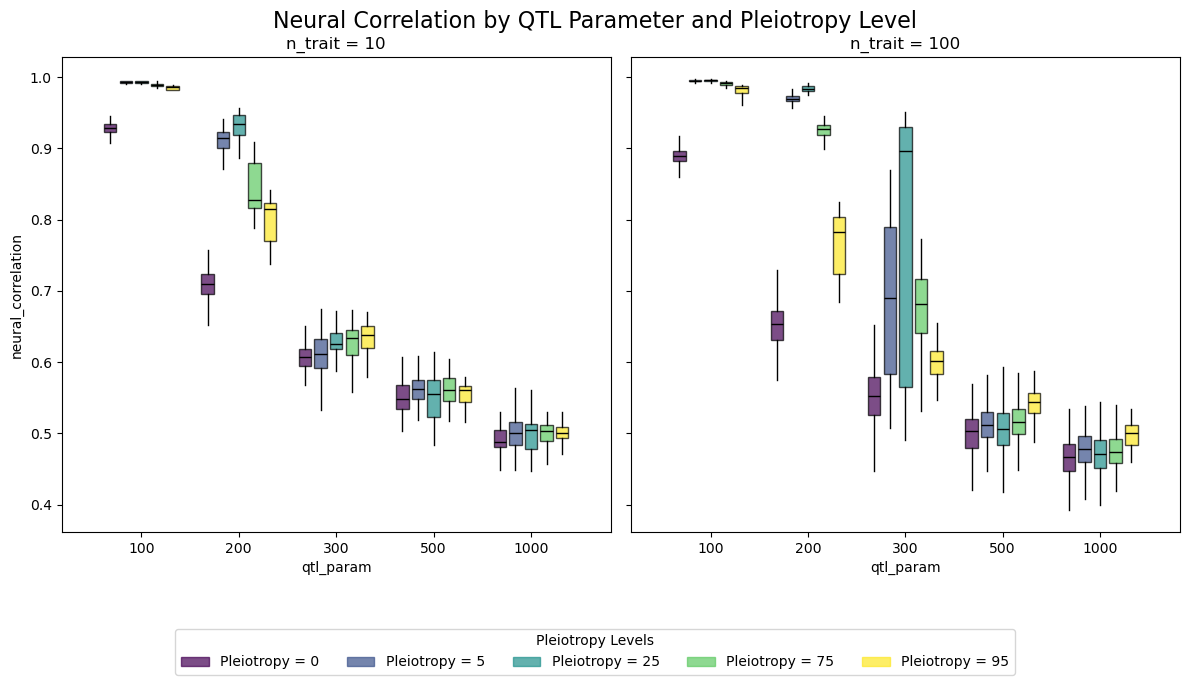

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your already properly formatted DataFrame

# Get unique values
qtl_param_values = sorted(df['qtl_param'].unique())
pleio_values = sorted(df['pleio'].unique())
unique_n_traits = sorted(df['n_trait'].unique())

# Create a figure with subplots in one row (one subplot per n_trait)
fig, axes = plt.subplots(1, len(unique_n_traits), figsize=(6*len(unique_n_traits), 6),
                         sharey=True)

# Create color map for pleiotropy levels
pleio_colors = plt.cm.viridis(np.linspace(0, 1, len(pleio_values)))
pleio_color_map = dict(zip(pleio_values, pleio_colors))

# Create each subplot (one per n_trait)
for i, n_trait in enumerate(unique_n_traits):
    # Get the correct axis for this subplot
    if len(unique_n_traits) == 1:
        ax = axes
    else:
        ax = axes[i]

    # Filter data for this n_trait
    n_trait_data = df[df['n_trait'] == n_trait]

    # Remove control traits
    n_trait_data = n_trait_data[~n_trait_data['trait_number'].isin([1, 2])]

    # For each qtl_param value
    for j, qtl_param in enumerate(qtl_param_values):
        # Filter data for this qtl_param
        qtl_data = n_trait_data[n_trait_data['qtl_param'] == qtl_param]

        if not qtl_data.empty:
            # Set the x-position for this group of boxplots
            x_pos = j + 1  # Base position (1, 2, 3, etc.)

            # Prepare data for side-by-side boxplots
            boxplot_data = []
            positions = []
            colors = []

            # Group by pleiotropy level
            for k, pleio_val in enumerate(pleio_values):
                # Filter data for this pleiotropy level
                pleio_data = qtl_data[qtl_data['pleio'] == pleio_val]

                if not pleio_data.empty:
                    values = pleio_data['neural_correlation'].values
                    if len(values) > 0:
                        boxplot_data.append(values)

                        # Calculate offset for side-by-side positioning
                        width = 0.8 / len(pleio_values)
                        offset = (k - (len(pleio_values)-1)/2) * width
                        positions.append(x_pos + offset)

                        colors.append(pleio_color_map[pleio_val])

            # Create boxplots for this qtl_param
            if boxplot_data:
                bplot = ax.boxplot(boxplot_data, positions=positions,
                                  patch_artist=True, widths=0.8/len(pleio_values)*0.8,
                                  showfliers=False, showcaps=False,
                                  medianprops={'color': 'black'},
                                  boxprops={'color': 'black'})

                # Color boxplots based on pleiotropy level
                for patch, color in zip(bplot['boxes'], colors):
                    patch.set(facecolor=color, alpha=0.7)

    # Set titles and labels
    ax.set_title(f'n_trait = {n_trait}')
    ax.set_xlabel('qtl_param')
    if i == 0:  # Only add y-label to the first subplot
        ax.set_ylabel('neural_correlation')

    # Set x-tick positions and labels
    ax.set_xticks(range(1, len(qtl_param_values) + 1))
    ax.set_xticklabels(qtl_param_values)


# Add a legend for pleiotropy levels
handles = []
labels = []
for pleio_val in pleio_values:
    patch = plt.Rectangle((0, 0), 1, 1, color=pleio_color_map[pleio_val], alpha=0.7)
    handles.append(patch)
    labels.append(f'Pleiotropy = {pleio_val}')

# Add the legend
fig.legend(handles, labels, title='Pleiotropy Levels',
           loc='upper center', bbox_to_anchor=(0.5, 0),
           ncol=min(5, len(pleio_values)))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the legend at the bottom

# Add overall title
plt.suptitle('Neural Correlation by QTL Parameter and Pleiotropy Level',
             fontsize=16, y=1.02)

# Show the plot
plt.show()

# If you want to save the figure
# plt.savefig('correlation_boxplots_by_n_trait.png', dpi=300, bbox_inches='tight')

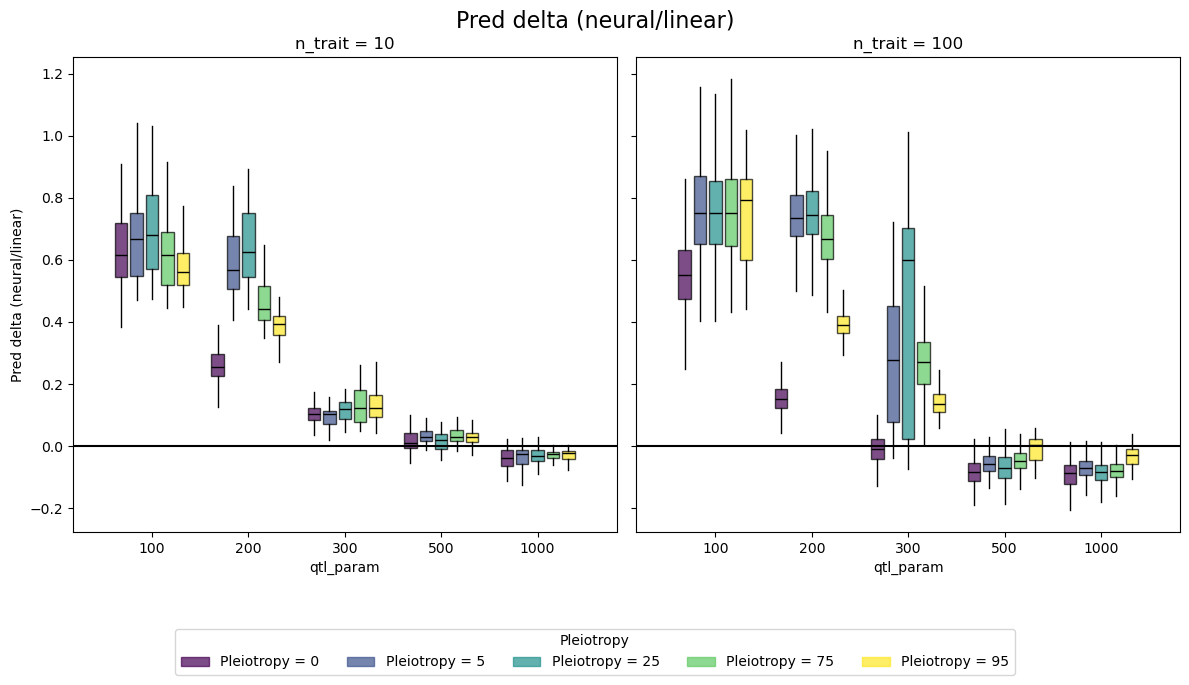

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your already properly formatted DataFrame

# Get unique values
qtl_param_values = sorted(df['qtl_param'].unique())
pleio_values = sorted(df['pleio'].unique())
unique_n_traits = sorted(df['n_trait'].unique())

# Create a figure with subplots in one row (one subplot per n_trait)
fig, axes = plt.subplots(1, len(unique_n_traits), figsize=(6*len(unique_n_traits), 6),
                         sharey=True)

# Create color map for pleiotropy levels
pleio_colors = plt.cm.viridis(np.linspace(0, 1, len(pleio_values)))
pleio_color_map = dict(zip(pleio_values, pleio_colors))

# Create each subplot (one per n_trait)
for i, n_trait in enumerate(unique_n_traits):
    # Get the correct axis for this subplot
    if len(unique_n_traits) == 1:
        ax = axes
    else:
        ax = axes[i]

    # Filter data for this n_trait
    n_trait_data = df[df['n_trait'] == n_trait]

    # For each qtl_param value
    for j, qtl_param in enumerate(qtl_param_values):
        # Filter data for this qtl_param
        qtl_data = n_trait_data[n_trait_data['qtl_param'] == qtl_param]

        if not qtl_data.empty:
            # Set the x-position for this group of boxplots
            x_pos = j + 1  # Base position (1, 2, 3, etc.)

            # Prepare data for side-by-side boxplots
            boxplot_data = []
            positions = []
            colors = []

            # Group by pleiotropy level
            for k, pleio_val in enumerate(pleio_values):
                # Filter data for this pleiotropy level
                pleio_data = qtl_data[qtl_data['pleio'] == pleio_val]

                if not pleio_data.empty:
                    values = pleio_data['difference'].values
                    if len(values) > 0:
                        boxplot_data.append(values)

                        # Calculate offset for side-by-side positioning
                        width = 0.8 / len(pleio_values)
                        offset = (k - (len(pleio_values)-1)/2) * width
                        positions.append(x_pos + offset)

                        colors.append(pleio_color_map[pleio_val])

            # Create boxplots for this qtl_param
            if boxplot_data:
                bplot = ax.boxplot(boxplot_data, positions=positions,
                                  patch_artist=True, widths=0.8/len(pleio_values)*0.8,
                                  showfliers=False, showcaps=False,
                                  medianprops={'color': 'black'},
                                  boxprops={'color': 'black'})

                # Color boxplots based on pleiotropy level
                for patch, color in zip(bplot['boxes'], colors):
                    patch.set(facecolor=color, alpha=0.7)

    # Set titles and labels
    ax.set_title(f'n_trait = {n_trait}')
    ax.set_xlabel('qtl_param')
    if i == 0:  # Only add y-label to the first subplot
        ax.set_ylabel('Pred delta (neural/linear)')

    # Set x-tick positions and labels
    ax.set_xticks(range(1, len(qtl_param_values) + 1))
    ax.set_xticklabels(qtl_param_values)
    ax.axhline(y=0, color='black')


# Add a legend for pleiotropy levels
handles = []
labels = []
for pleio_val in pleio_values:
    patch = plt.Rectangle((0, 0), 1, 1, color=pleio_color_map[pleio_val], alpha=0.7)
    handles.append(patch)
    labels.append(f'Pleiotropy = {pleio_val}')

# Add the legend
fig.legend(handles, labels, title='Pleiotropy',
           loc='upper center', bbox_to_anchor=(0.5, 0),
           ncol=min(5, len(pleio_values)))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the legend at the bottom



# Add overall title
plt.suptitle('Pred delta (neural/linear)',
             fontsize=16, y=1.02)

# Show the plot
plt.show()